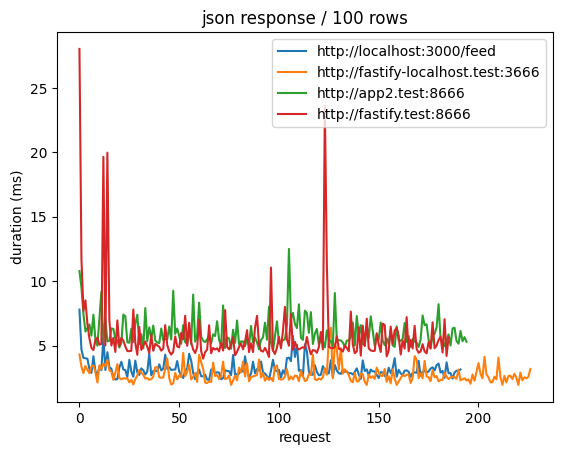

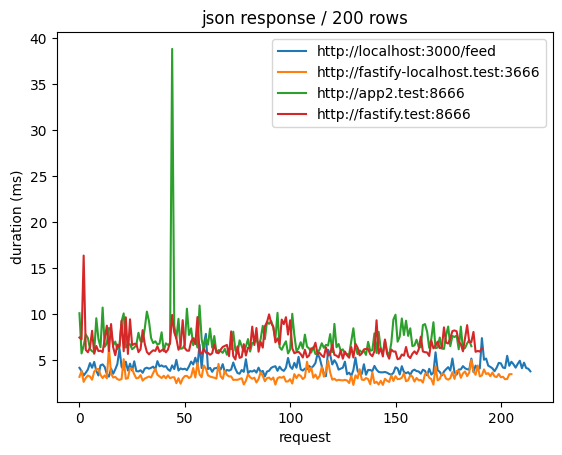

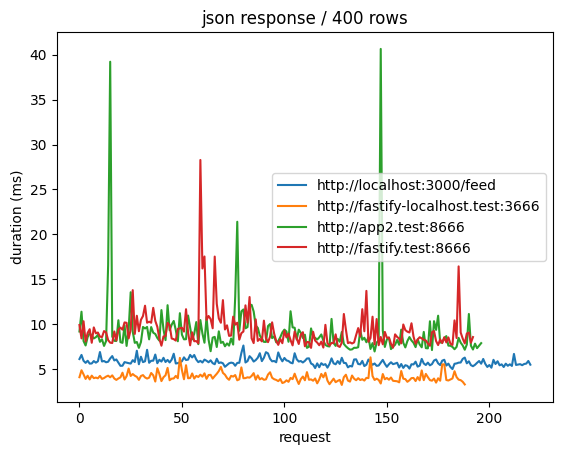

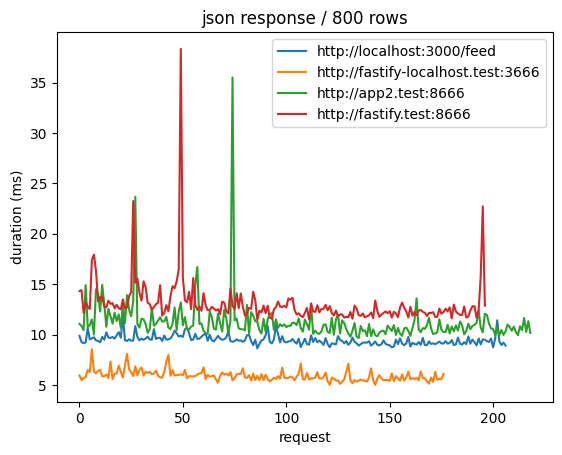

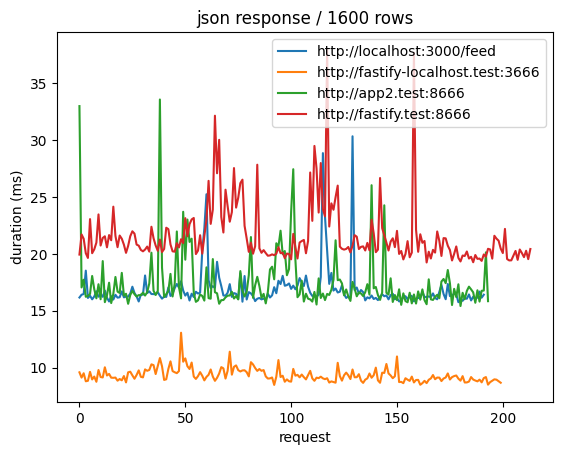

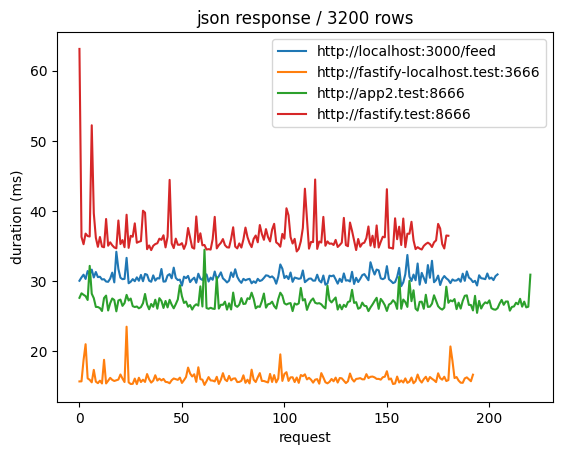

In [3]:

# send 1000 requests mixing the targets randomly
# compute each target response time
# plot the results

import random
import requests
import time
import hashlib

def send_requests_randomly(targets, nb_requests, limit):
    durations = {}
    # init durations for each target
    for target in targets:
        durations[target] = []

    for i in range(nb_requests):
        target = random.choice(targets)
        start = time.time()
        # md5 hash of start
        md5hash = hashlib.md5(str(start).encode('utf-8')).hexdigest()
        # add limit as GET parameter
        url = f'{target}?limit={limit}&md5={md5hash}'
        response = requests.get(url)
        end = time.time()
        duration = 1000 * (end - start)
        # store duration for target
        durations[target].append(duration)
        # print(f'{i} {url} {duration:.2f}ms')

        # save response body to file
        target_name = target.replace('http://', '')
        target_name = target_name.replace('https://', '')
        # remove port by replacing : with -
        target_name = target_name.replace(':', '-')
        target_name = target_name.replace('/', '-')

        target_file = f'my-json/{limit}-{target_name}.json'
        with open(target_file, 'w') as f:
            # get response body
            body = response.text
            # write to file
            f.write(body)
            f.write('\n')

        # time.sleep(0.1)

    return durations


import matplotlib.pyplot as plt
import numpy as np

def run_test(targets, nb_requests, limit):
    requests = send_requests_randomly(targets, nb_requests, limit)

    for target, durations in requests.items():
        # max len 50 chars for target
        label_target = target[:50]
        plt.plot(durations, label=label_target)

    # add title
    plt.title(f'json response / {limit} rows')
    # add x axis label
    plt.xlabel('request')
    # add y axis label
    plt.ylabel('duration (ms)')
    # add legend
    plt.legend()
    # save chart to file {limit}rows.png
    plt.savefig(f'{limit}rows.png')
    # build and show chart
    plt.show()

# DON'T FORGET TO START THE SERVERS BEFORE...
targets = [
    'http://localhost:3000/feed', # Node Prisma/Express (localhost)
#    'http://localhost:3666', # PHP (localhost)
#    'http://php-localhost.test:3666', # PHP (localhost)
#    'http://127.0.0.1:8000/', # FASTAPI (localhost)
#    'http://fastify-localhost.test:3000', # Fastify (localhost)
    'http://fastify-localhost.test:3666', # Fastify (localhost)
    'http://app2.test:8666', # PHP (Docker + Nginx + PHP-FPM)
#    'http://localhost/', # laravel sail (localhost)
    'http://fastify.test:8666',
#    'http://php.test:8666/perf.json', # GAIA
#    'http://localhost:8444/', # WP
#    'https://banana.fr8t.net/',
#    'https://lo.go.yo.fr/',
#    'https://lo.go.yo.fr/onepage/', # Planet Hoster / PHP
#    'http://symfony.test:8666/fr/blog/',
#    'http://symfony.test:8666/fr/blog/posts/lorem-ipsum-dolor-sit-amet-consectetur-adipiscing-elit',
#    'http://127.0.0.1:8000/fr/blog/posts/lorem-ipsum-dolor-sit-amet-consectetur-adipiscing-elit', #symfony local
#    'http://127.0.0.1:8000/fr/blog/perf',
#    'http://symfony.test:8666/fr/blog/perf',
#    'http://laravel.test:8666/perf', # DOCKER LARAVEL
#    'http://laravel-localhost.test:3555/perf' # LOCAL LARAVEL
]

# CLI
# php artisan serve --host=laravel-localhost.test --port=3555
# Apache Bench
# ab -n100 http://app2.test:8666

limits = [100, 200, 400, 800, 1600, 3200]
# limits = [ 100 ]
nb_requests = 200 * len(targets)

# create dir my-json if not exists
!mkdir -p ./my-json

# remove all my-*json files
!rm ./my-json/*.json

# loop over limits
for limit in limits:
    # run test for each limit
    run_test(targets, nb_requests, limit)



